In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tinymlgen import port

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#build data generators for training and validaton

split = 0.2

# Define dirs and files
train_data_dir = 'data/classification'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(#preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                                   rescale =1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize,
                                                    subset = 'training',
                                                    shuffle = True)

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = 128,
                                                        class_mode = 'binary',
                                                        target_size = imsize,
                                                        subset='validation',
                                                        shuffle = True)

Found 686 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


In [3]:
test_images, test_labels = next(validation_generator)

In [4]:
filepath = './models/mobilenetv2_water_18finetune'

model = tf.keras.models.load_model(filepath)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

                                                                                                  
 dense_out (Dense)              (None, 1)            1025        ['dropout_4[0][0]']              
                                                                                                  
Total params: 6,719,553
Trainable params: 6,685,441
Non-trainable params: 34,112
__________________________________________________________________________________________________


In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        ## Ideally we should do a validation calibration but we are using all of the training data for max acc
#        x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        x =np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8
converter.inference_output_type = tf.uint8  # or tf.int8

tflite_model = converter.convert()

with open('mobilenetv2_water_18ft9.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: C:\Users\joe\AppData\Local\Temp\tmpxgr6ms3j\assets


C:\Users\joe\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


(686, 224, 224, 3)


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [ ]:
# test the quantized model just in case

In [6]:
# Function to use the model to predict from images
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

  # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    predictions = np.zeros((len(test_image_indices),), dtype=int)
    scaled_preds = np.zeros((len(test_image_indices),), dtype=int)
    
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point
            
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        # need to scale output 0-255 -> 0-1
        output = (output/255.)
        # decision threshold
        predictions[i] = output.round()
    # send the predictions (0 or 1) back
    return predictions

In [7]:
# Function to test the model on one image at a time
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=(predictions)))
    plt.grid(False)
    predictions


In [8]:
# load the quantized model
tflite_model_quant = "mobilenetv2_water_18ft9.tflite"

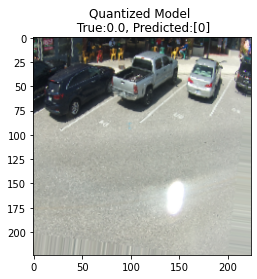

In [9]:
# test one image
# change test_image_index to various indices to test different images
test_image_index = 0
test_model(tflite_model_quant, test_image_index, model_type="Quantized")

In [10]:
# function that tests multiple images and checks the accuracy of the predictions
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
        model_type, accuracy, len(test_images)))
    
    print(predictions)


In [11]:
# test the model
evaluate_model(tflite_model_quant, model_type="Quantized")

Quantized model accuracy is 77.3438% (Number of test samples=128)
[0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0]


In [ ]:
# use this unix command to convert the .tflite file into a C array
# xxd -i converted_model.tflite > model_data.cc